THIS NOTEBOOK AIMS TO TRAIN VIT L 16 OXFORD III PETS DATASET

In [1]:
import torch
import torchvision
from torchinfo import summary
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

/home/emir/miniconda3/envs/mlptorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
vit_l_16_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
vit_l_16_model = torchvision.models.vit_l_16(vit_l_16_weights).to(device)

/home/emir/miniconda3/envs/mlptorch/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [5]:
from train_model import print_summary

In [6]:
summary(model=vit_l_16_model, 
          input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
          # col_names=["input_size"], # uncomment for smaller output
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           1,024                True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 197, 10

In [7]:
vit_transforms = vit_l_16_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
dataset_dir = "../datasets/"

In [9]:
transform_tensor = transforms.Compose([
    transforms.Resize(size=[224]),
    transforms.ToTensor()])

In [10]:
train_data = torchvision.datasets.OxfordIIITPet(root=dataset_dir,
                                                download=True,
                                                split="trainval",
                                                transform=vit_transforms)
test_data = torchvision.datasets.OxfordIIITPet(root=dataset_dir,
                                                download=True,
                                                transform=vit_transforms,
                                                split="test")

In [11]:
from prepare_data import create_dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_data=train_data, test_data=test_data, data_folder_imported=True, transform=vit_transforms, batch_size=128)

In [12]:
class_names

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

lets show some images

In [13]:
len(train_dataloader), len(test_dataloader)

(29, 29)

In [14]:
len(train_data)

3680

In [15]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[2], label_batch[2]

In [16]:
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Wheaten Terrier')

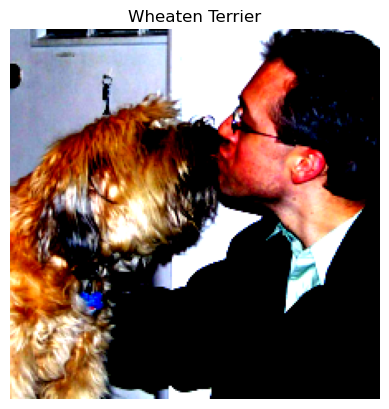

In [17]:
#should permute
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [18]:
for parameter in vit_l_16_model.parameters():
    parameter.requires_grad = False

In [19]:
vit_l_16_model.heads = nn.Sequential(nn.Linear(in_features=1024, out_features=len(class_names)))
summary(model=vit_l_16_model, 
          input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
          # col_names=["input_size"], # uncomment for smaller output
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 37]             1,024                Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   (787,456)            False
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              False
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      (12,596,224)         False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 

learning rate decay(cosine), gradient clipping, learning rate warmup 

In [23]:
#learning scheduler for warmups and weight decays
optimizer = torch.optim.SGD(momentum=0.9, lr=0.003, params=vit_l_16_model.parameters())
loss_fn = nn.CrossEntropyLoss()
lr_sc = torch.optim.lr_scheduler.CosineAnnealingLR(T_max=500, optimizer=optimizer, verbose=False)

In [24]:
from train_model import train
vit_pets_results = train(model=vit_l_16_model,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        lr_scheduler=lr_sc,
                        epochs=14,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        device=device)

  7%|▋         | 1/14 [01:26<18:41, 86.31s/it]

0.0029751678074929934
Epoch: 1 | train_loss: 0.6173 | train_acc: 0.9353 | test_loss: 0.5987 | test_acc: 0.9100


 14%|█▍        | 2/14 [02:53<17:19, 86.61s/it]

0.0029014934136849173
Epoch: 2 | train_loss: 0.4940 | train_acc: 0.9440 | test_loss: 0.5041 | test_acc: 0.9154


 21%|██▏       | 3/14 [04:19<15:53, 86.73s/it]

0.0027814161475489415
Epoch: 3 | train_loss: 0.4141 | train_acc: 0.9459 | test_loss: 0.4489 | test_acc: 0.9168


 29%|██▊       | 4/14 [05:46<14:28, 86.83s/it]

0.0026189117181362725
Epoch: 4 | train_loss: 0.3638 | train_acc: 0.9515 | test_loss: 0.4141 | test_acc: 0.9181


 36%|███▌      | 5/14 [07:13<13:00, 86.71s/it]

0.0024193605804794646
Epoch: 5 | train_loss: 0.3307 | train_acc: 0.9531 | test_loss: 0.3903 | test_acc: 0.9195


 43%|████▎     | 6/14 [08:40<11:34, 86.81s/it]

0.002189369790932232
Epoch: 6 | train_loss: 0.3065 | train_acc: 0.9543 | test_loss: 0.3734 | test_acc: 0.9184


 50%|█████     | 7/14 [10:07<10:08, 86.86s/it]

0.0019365542502424067
Epoch: 7 | train_loss: 0.2885 | train_acc: 0.9569 | test_loss: 0.3608 | test_acc: 0.9200


 57%|█████▋    | 8/14 [11:34<08:41, 86.85s/it]

0.0016692845773102214
Epoch: 8 | train_loss: 0.2745 | train_acc: 0.9577 | test_loss: 0.3512 | test_acc: 0.9195


 64%|██████▍   | 9/14 [13:01<07:14, 86.88s/it]

0.0013964099614283904
Epoch: 9 | train_loss: 0.2642 | train_acc: 0.9593 | test_loss: 0.3443 | test_acc: 0.9195


 71%|███████▏  | 10/14 [14:27<05:47, 86.83s/it]

0.0011269651692527173
Epoch: 10 | train_loss: 0.2560 | train_acc: 0.9608 | test_loss: 0.3390 | test_acc: 0.9195


 79%|███████▊  | 11/14 [15:55<04:20, 86.91s/it]

0.00086987140738229
Epoch: 11 | train_loss: 0.2503 | train_acc: 0.9604 | test_loss: 0.3351 | test_acc: 0.9205


 86%|████████▌ | 12/14 [17:21<02:53, 86.87s/it]

0.0006336409448665986
Epoch: 12 | train_loss: 0.2460 | train_acc: 0.9617 | test_loss: 0.3323 | test_acc: 0.9200


 93%|█████████▎| 13/14 [18:48<01:26, 86.80s/it]

0.0004260952754672531
Epoch: 13 | train_loss: 0.2421 | train_acc: 0.9627 | test_loss: 0.3305 | test_acc: 0.9200


100%|██████████| 14/14 [20:14<00:00, 86.78s/it]

0.00025410615120628104
Epoch: 14 | train_loss: 0.2406 | train_acc: 0.9622 | test_loss: 0.3293 | test_acc: 0.9208


So first results with cosinelearning rate was really baddd so lets try to read paper again

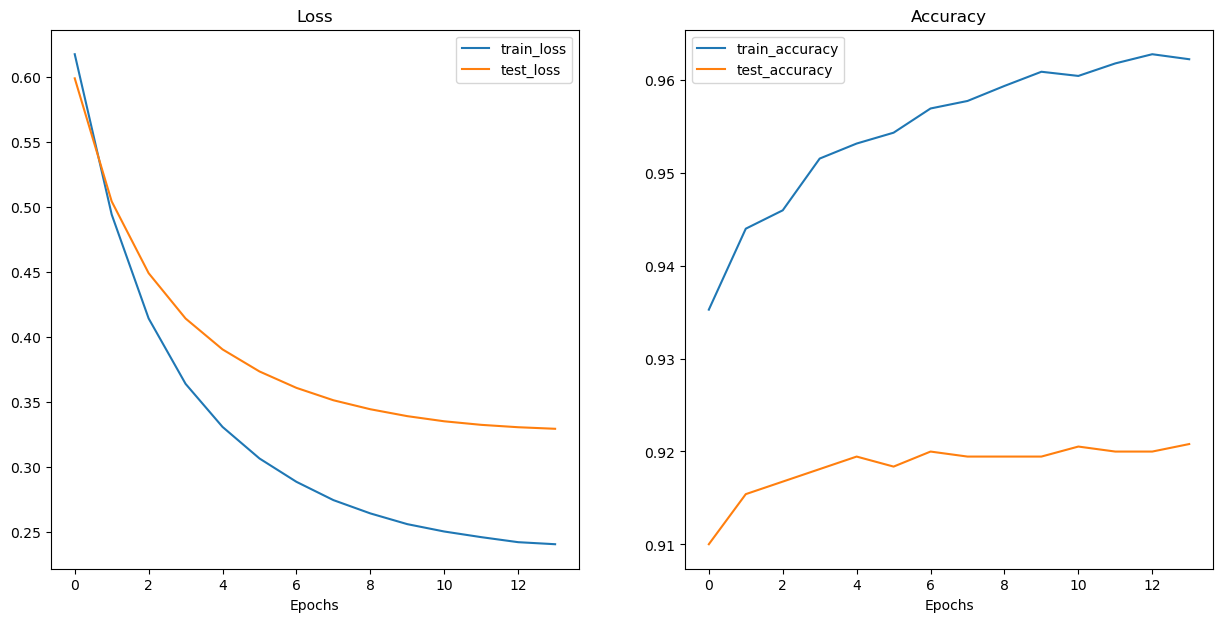

In [25]:
from plot_loss_function import plot_loss_function

plot_loss_function(vit_pets_results)